In [4]:
import sys 
sys.path.append('../Python-modules/')
from file_helpers import cache_hatch_dates, calculate_bee_lifespans_from_hatchdates, calculate_bee_lifespans_from_detections, calculate_bee_lifespans_combined 
from datetime import timedelta, datetime
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import bb_utils.meta
%matplotlib inline
meta = bb_utils.meta.BeeMetaInfo()

cache_location_prefix = "../../caches/"
detections_cache_path = cache_location_prefix + "Detections/"

### Goal

This notebook was made to produce some easy plots, but can (and maybe should) be used to filter out suspicious data from the dataset (like 0-day lifespans of lifespans that end on the same day as the experiment)

In [5]:
h = calculate_bee_lifespans_from_hatchdates()
d = calculate_bee_lifespans_from_detections()
c = calculate_bee_lifespans_combined()
diff = h - d 

True

In [3]:
def plot_missing_data(lifespans, title_suffix=""):
    null_ids = lifespans[lifespans.isnull()].index.to_series()
    zeros_ids = lifespans[lifespans==0].index.to_series()
    fig = plt.figure(figsize=(25,1))
    ax = fig.add_subplot(111, title = "NaTs and zeroes " + title_suffix)
    ax.set_xlim(0, 4096)
    plt.plot(null_ids, np.zeros_like(null_ids), '|')
    plt.plot(zeros_ids, np.zeros_like(zeros_ids), '|')

There are 260 NaTs (invalid dates) and 18 zeroes in lifespans calculated from hatchdates (out of  2969 ).
There are 316 0-day lifespans in lifespans calculated from detections (out of  2969 ).
There are 175 0-day lifespans in lifespans calculated from hatchdates + detections (out of  2969 ).


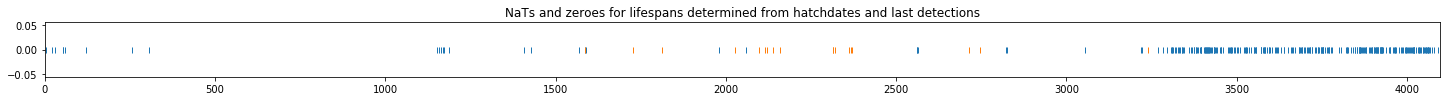

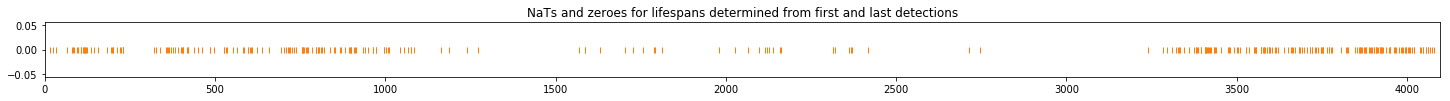

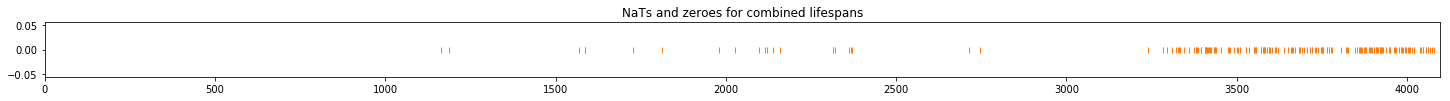

In [4]:
plot_missing_data(h, "for lifespans determined from hatchdates and last detections")
plot_missing_data(d, "for lifespans determined from first and last detections")
plot_missing_data(c, "for combined lifespans")

print("There are", h.isnull().sum(), "NaTs (invalid dates) and", len(h) - len(h.nonzero()[0]), "zeroes in lifespans calculated from hatchdates (out of ", len(h),").")
print("There are", len(d) - len(d.nonzero()[0]), "0-day lifespans in lifespans calculated from detections (out of ", len(d),").")
print("There are", len(c) - len(c.nonzero()[0]), "0-day lifespans in lifespans calculated from hatchdates + detections (out of ", len(c),").")

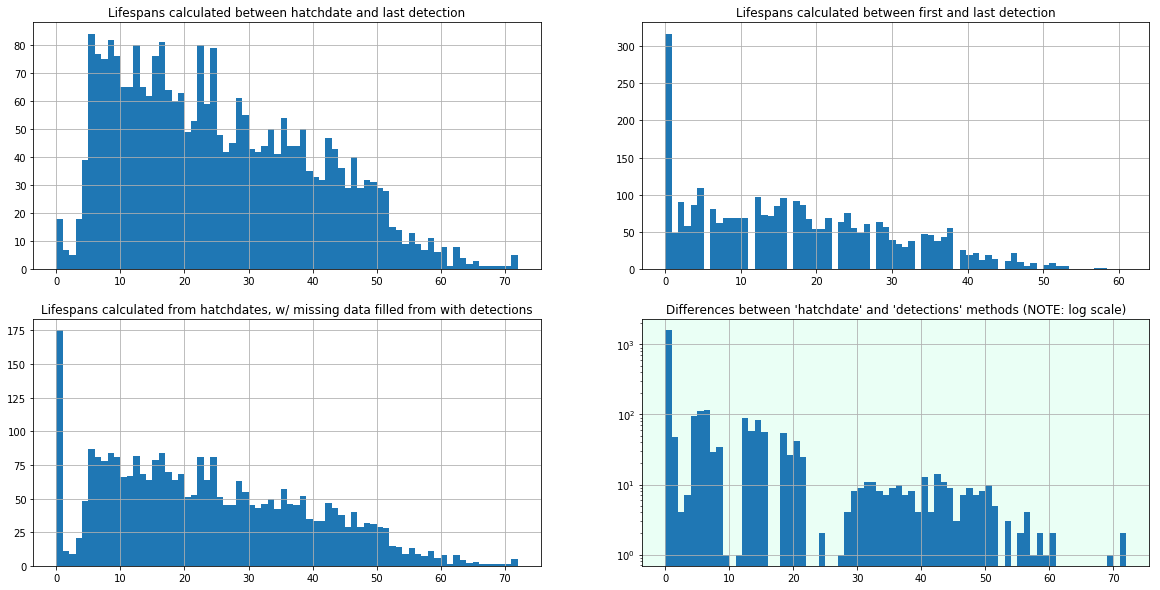

In [5]:
fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221, title="Lifespans calculated between hatchdate and last detection")
ax2=fig.add_subplot(222, title="Lifespans calculated between first and last detection")
ax3=fig.add_subplot(223, title="Lifespans calculated from hatchdates, w/ missing data filled from with detections")
ax4=fig.add_subplot(224, title="Differences between 'hatchdate' and 'detections' methods (NOTE: log scale)")
ax4.set_facecolor('#eafff5')
ax4.set_yscale('log')

h.hist(bins=72, ax=ax1)
d.hist(bins=72, ax=ax2)
c.hist(bins=72, ax=ax3)
diff.hist(bins=72, ax=ax4)

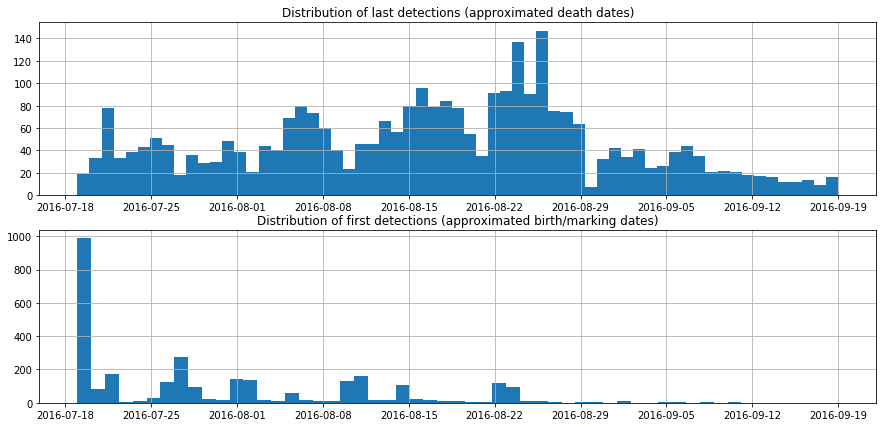

In [6]:
last_alive_path = detections_cache_path+'Last_day_alive.csv'
last_day_alive_df = pd.read_csv(last_alive_path, 
                                parse_dates=['max'], 
                                usecols=['max', 'bee_id'])
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211, title="Distribution of last detections (approximated death dates)")
last_day_alive_df['max'].hist(bins=last_day_alive_df['max'].nunique())


first_alive_path = detections_cache_path+'First_day_alive.csv'
first_day_alive_df = pd.read_csv(first_alive_path, 
                                parse_dates=['min'], 
                                usecols=['min', 'bee_id'])
ax2 = fig.add_subplot(212, title="Distribution of first detections (approximated birth/marking dates)")

first_day_alive_df['min'].hist(bins=first_day_alive_df['min'].nunique())

Note: bees with 'death' dates on the last day of the experiment were removed from the rest of the data in this notebook (both before and after this point)

In [20]:
last_day_alive_df.index = last_day_alive_df['bee_id']
last_day_alive_df = last_day_alive_df.drop(['bee_id'], axis=1)

In [27]:
lifespans_and_deaths_df = last_day_alive_df.join(c, how='inner')

In [65]:
lifespans_and_deaths_df['min'] = lifespans_and_deaths_df['max'] - pd.to_timedelta(lifespans_and_deaths_df['life_span'], unit='d')
lifespans_and_deaths_df = lifespans_and_deaths_df[['min', 'max', 'life_span']]

In [66]:
first_day = lifespans_and_deaths_df['min'].min()
last_day = lifespans_and_deaths_df['max'].max()
hivedays = pd.date_range(first_day, last_day, freq='D')

In [81]:
survivors = []
for day in hivedays:
    survivors_on_day = 0
    for index, bee in lifespans_and_deaths_df.iterrows():
        if day >= bee['min'] and day <= bee['max']:
            survivors_on_day += 1 
    survivors.append(survivors_on_day)

In [106]:
survivors = pd.Series(survivors)
hivedays = pd.Series(hivedays)
survivors_per_day = pd.concat([hivedays, survivors], axis=1, keys=['date', '#survivors'])
survivors_per_day_num = survivors_per_day.drop(['date'], axis=1)

Text(0,0.5,'Number of bees alive')

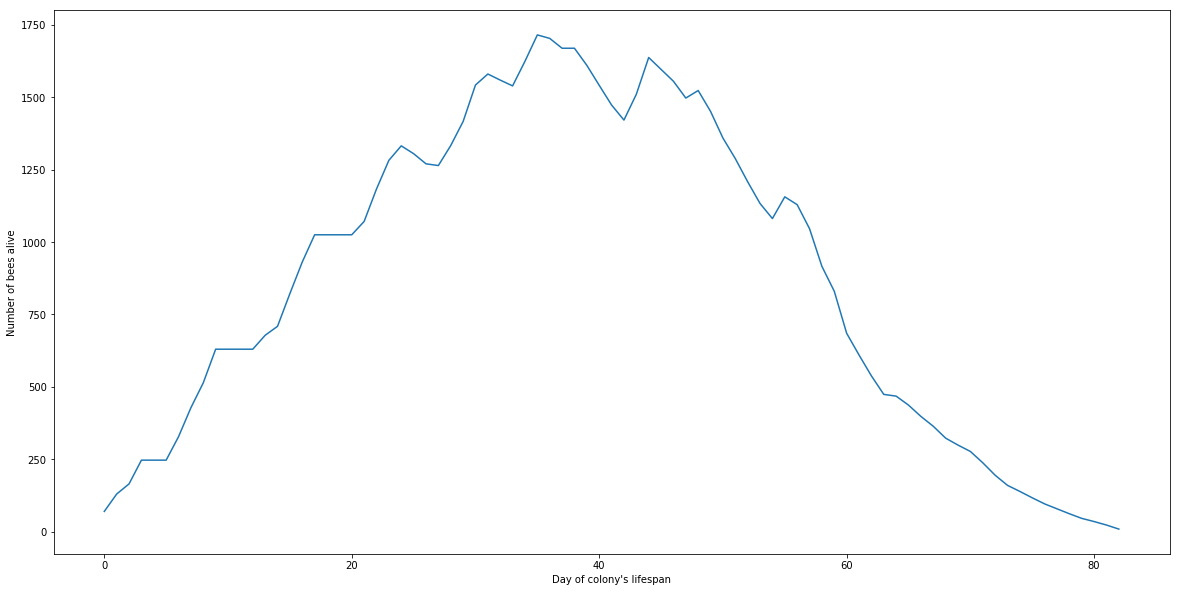

In [100]:
ax = survivors_per_day_num.plot(figsize=(20,10), legend=None)
ax.set_xlabel("Day of colony's lifespan")
ax.set_ylabel("Number of bees alive")

In [117]:
lifespans = lifespans_and_deaths_df['life_span']

#TODO: have a version without this line
# lifespans = lifespans[lifespans['life_span']>0]
type(lifespans)

pandas.core.series.Series

In [119]:
lifespans.max()

72

In [144]:
surv = []
for i in range(0,73):
    n = lifespans[lifespans > i].count()
    surv.append(n)

In [152]:
surv = pd.Series(surv)
surv = surv/surv.max()

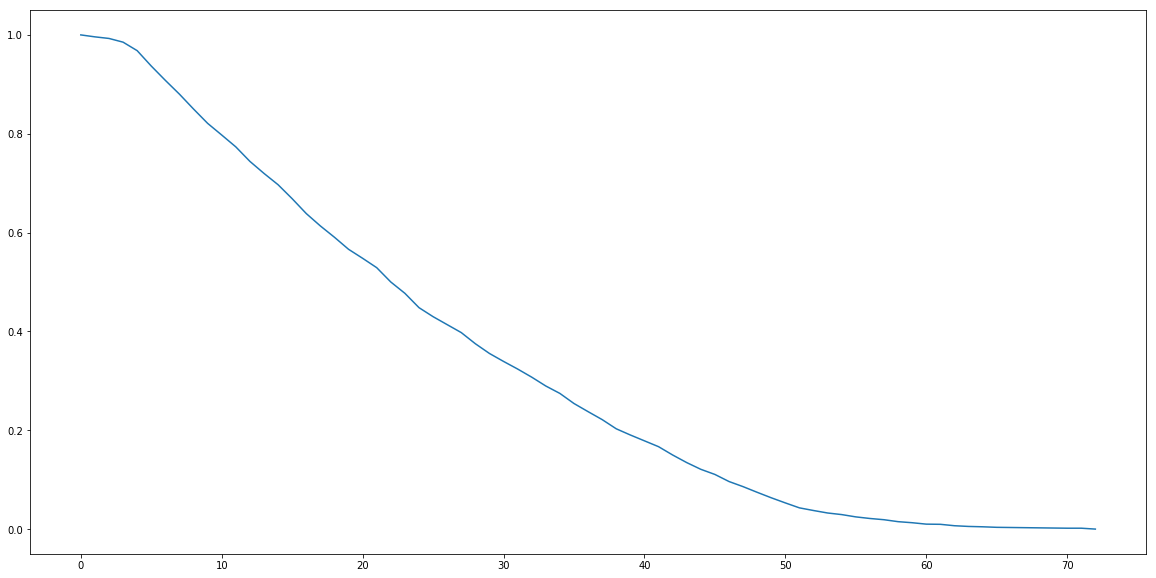

In [153]:
surv.plot(figsize=(20,10))

In [1]:
# TODO: there are bees that were tagged *before* the observation period, 
# so that could account for part of the difference between the hatchdates and the first detections